# Import libraries

In [1]:
# Loading the dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import datetime
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import preprocess_input
import pandas as pd

# Load the trained Model

In [2]:
# Loading the trained model
IMG_SIZE = 128
model_path = '/content/mnist_cnn_model (4).keras'
model = load_model(model_path)


# Load class name

In [3]:
import tensorflow as tf

# Load MNIST dataset directly from the web
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# The classes in MNIST are digits 0–9
class_names = [str(i) for i in range(10)]

print("Loaded Classes:", class_names)
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Loaded Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


✅ Model loaded.


<IPython.core.display.Javascript object>

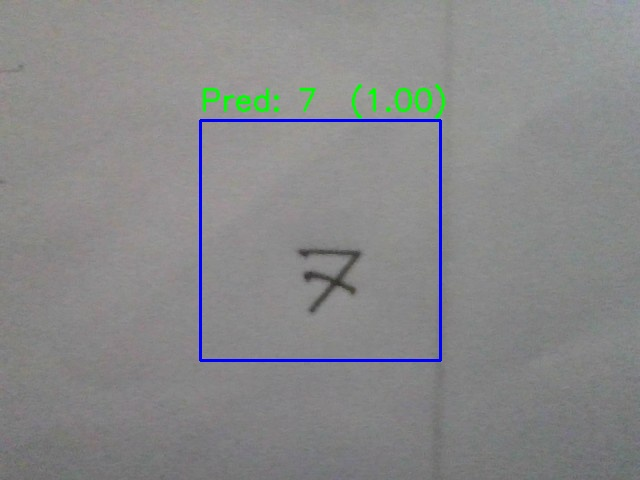

🔎 Debug: threshold | digit crop | 28x28 fed to model


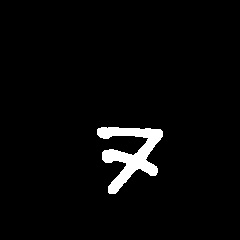

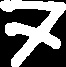

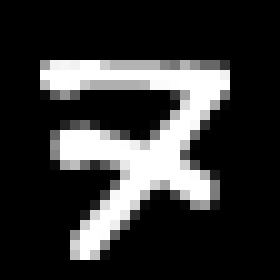

Top-3: [(7, 0.9999409914016724), (2, 5.798506026621908e-05), (3, 9.960007218978717e-07)]
✅ Prediction: 7  Confidence: 1.000


In [6]:

# Robust Webcam MNIST Recognition (Colab + JS capture)

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import cv2, numpy as np, tensorflow as tf
from base64 import b64decode

# Load your trained model
MODEL_PATH = "/content/mnist_cnn_model (4).keras"   # change if needed
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded.")

#  Helpers
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    return cv2.imdecode(jpg_as_np, flags=1)

def _center_by_moments(img28):
    """Shift the 28x28 binary image so its centroid is centered (like MNIST)."""
    m = cv2.moments(img28)
    if abs(m["m00"]) < 1e-5:
        return img28
    cx, cy = m["m10"]/m["m00"], m["m01"]/m["m00"]
    tx, ty = int(14 - cx), int(14 - cy)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img28, M, (28, 28))

def preprocess_mnist_robust(roi, return_debug=False):
    """
    Make ROI look like MNIST:
    1) grayscale -> blur -> Otsu threshold
    2) auto-invert so digit is white on black
    3) largest contour crop
    4) resize to ~20x20, place on 28x28 canvas
    5) center by moments
    """
    # 1) grayscale & denoise a bit (helps Otsu)
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # 2) Try INV first (works for dark digit on light paper)
    _, th_inv = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    white_ratio = np.mean(th_inv == 255)

    # If almost everything is white, try the non-inverted version and invert it after
    if white_ratio > 0.9:
        _, th_norm = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresh = cv2.bitwise_not(th_norm)  # ensure digit is white, bg black
    else:
        thresh = th_inv

    # 3) clean small specks, thicken a bit
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)

    # Find largest contour (the digit)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    H, W = thresh.shape[:2]
    debug_images = {"thresh": thresh.copy()}

    if not contours:
        canvas = np.zeros((28,28), np.uint8)
        x28 = canvas.astype("float32")/255.0
        x28 = x28.reshape(1,28,28,1)
        return (x28, debug_images) if return_debug else x28

    c = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)

    # Reject if too small relative to ROI (nothing meaningful)
    if w*h < 0.001 * (W*H):
        canvas = np.zeros((28,28), np.uint8)
        x28 = canvas.astype("float32")/255.0
        x28 = x28.reshape(1,28,28,1)
        return (x28, debug_images) if return_debug else x28

    digit = thresh[y:y+h, x:x+w]

    # 4) resize to fit 20x20 keeping aspect ratio
    scale = 20.0 / max(w, h)
    new_w, new_h = max(1, int(w*scale)), max(1, int(h*scale))
    digit_resized = cv2.resize(digit, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # place on 28x28 canvas
    canvas = np.zeros((28,28), dtype=np.uint8)
    x_off = (28 - new_w)//2
    y_off = (28 - new_h)//2
    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = digit_resized

    # 5) center by moments (MNIST-like centering)
    canvas = _center_by_moments(canvas)

    debug_images.update({"digit_cropped": digit, "canvas28": canvas})

    # normalize for model
    x28 = (canvas.astype("float32") / 255.0).reshape(1,28,28,1)
    return (x28, debug_images) if return_debug else x28

#  Single-shot capture via JS (Colab)
def take_photo_and_recognize(quality=0.9, roi_size=240, show_debug=True):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const btn = document.createElement('button');
        btn.textContent = 'Capture';
        btn.style.marginBottom = '8px';
        div.appendChild(btn);
        const video = document.createElement('video');
        video.style.display = 'block';
        video.style.border = '1px solid #ccc';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => btn.onclick = resolve);
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    frame = js_to_image(data)

    # draw ROI box (centered)
    H, W, _ = frame.shape
    s = roi_size
    x1, y1 = (W - s)//2, (H - s)//2
    x2, y2 = x1 + s, y1 + s
    roi = frame[y1:y2, x1:x2].copy()

    # preprocess + predict
    x28, dbg = preprocess_mnist_robust(roi, return_debug=True)
    probs = model.predict(x28, verbose=0)[0]
    top3 = probs.argsort()[-3:][::-1]
    pred = int(top3[0])
    conf = float(probs[pred])

    # annotate and display
    out = frame.copy()
    cv2.rectangle(out, (x1,y1), (x2,y2), (255, 0, 0), 2)
    cv2.putText(out, f"Pred: {pred}  ({conf:.2f})", (x1, max(30, y1-10)),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)
    cv2.imwrite("captured_with_pred.jpg", out)
    display(Image("captured_with_pred.jpg"))

    # show debug views (what the model sees)
    if show_debug:
        cv2.imwrite("debug_thresh.jpg", dbg["thresh"])
        cv2.imwrite("debug_digit_crop.jpg", dbg["digit_cropped"])
        # upscale 28x28 for visibility
        canvas_big = cv2.resize(dbg["canvas28"], (280, 280), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite("debug_canvas28.jpg", canvas_big)
        print("🔎 Debug: threshold | digit crop | 28x28 fed to model")
        display(Image("debug_thresh.jpg"))
        display(Image("debug_digit_crop.jpg"))
        display(Image("debug_canvas28.jpg"))

    # print top-3 to sanity-check confidence
    print("Top-3:", [(int(k), float(probs[k])) for k in top3])
    print(f" Prediction: {pred}  Confidence: {conf:.3f}")

#  Run once
take_photo_and_recognize()


In [8]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Parameters
IMG_SIZE = 28

# Load MNIST test set
(_, _), (x_test, y_test) = mnist.load_data()

# Preprocess images
x_test = x_test.astype("float32") / 255.0
x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # grayscale channel

# Convert labels to one-hot encoding
y_test_cat = to_categorical(y_test, 10)  # 10 classes

# Evaluate model
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=1)
print(f"\n Test Accuracy: {test_acc*100:.1f}%")
print(f" Test Loss: {test_loss*100:.1f}%\n")

# First 10 predictions vs actual
preds = model.predict(x_test[:10])
y_pred = np.argmax(preds, axis=1)
print("First 10 Predictions vs Actuals:")
for i in range(10):
    print(f"Image {i+1}: Predicted = {y_pred[i]}, Actual = {y_test[i]}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9876 - loss: 0.0346

✅ Test Accuracy: 99.1%
✅ Test Loss: 2.7%

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
First 10 Predictions vs Actuals:
Image 1: Predicted = 7, Actual = 7
Image 2: Predicted = 2, Actual = 2
Image 3: Predicted = 1, Actual = 1
Image 4: Predicted = 0, Actual = 0
Image 5: Predicted = 4, Actual = 4
Image 6: Predicted = 1, Actual = 1
Image 7: Predicted = 4, Actual = 4
Image 8: Predicted = 9, Actual = 9
Image 9: Predicted = 5, Actual = 5
Image 10: Predicted = 9, Actual = 9
